# Data research

created: 13/2/2026 <br>
updated: 14/2/2026

<i>Note: I was using sqlite3 instead of duckdb in order to use a built-in package.</i>

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
conn = sqlite3.connect(database='Veritas-Data-Set.db')
pd.read_csv('Veritas-Data-Set.csv').to_sql(name='data_table', con=conn, index=False)
print('Database structure:')
display(pd.read_sql('SELECT * FROM data_table LIMIT 5', conn))
print('Number of records:')
display(pd.read_sql('SELECT COUNT(id) FROM data_table', conn))
conn.close()

Database structure:


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


Number of records:


,COUNT(id)
0,82332


## Protocol analysis

In [5]:
conn = sqlite3.connect(database='Veritas-Data-Set.db')
display(pd.read_sql('SELECT proto AS protocol, COUNT(proto) AS protocol_count FROM data_table GROUP BY proto ORDER BY protocol_count DESC', conn))
conn.close()

,protocol,protocol_count
0,tcp,43095
1,udp,29418
2,unas,3515
3,arp,987
4,ospf,676
...,...,...
126,aes-sp3-d,32
127,a/n,32
128,3pc,32
129,ib,31


The two most common protocols are TCP and UDP.

## Traffic analysis

In [6]:
conn = sqlite3.connect(database='Veritas-Data-Set.db')
display(pd.read_sql('SELECT proto AS protocol, SUM(sbytes+dbytes) AS total_bytes FROM data_table GROUP BY proto ORDER BY total_bytes DESC', conn))
conn.close()

,protocol,total_bytes
0,tcp,1724299718
1,udp,10350834
2,sctp,6899706
3,ospf,4531812
4,unas,703000
...,...,...
126,igp,5940
127,ggp,5940
128,emcon,5940
129,egp,5940


The protocol responsible for the highest traffic is TCP with total volume of 1.72GB. This is probably due to the handshake between client and server (which increases volume relative to connectionless protocols like UDP), and due to the prevalence of the protocol.

## Ratio analysis

In [7]:
conn = sqlite3.connect(database='Veritas-Data-Set.db')
display(pd.read_sql('SELECT *, sbytes/(dbytes+1) AS ratio FROM data_table ORDER BY ratio DESC LIMIT 5', conn))
conn.close()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,ratio
0,65560,59.382812,ospf,-,INT,124,0,33728,0,2.071306,...,2,0,0,0,3,3,0,Fuzzers,1,33728
1,65563,59.382812,ospf,-,INT,124,0,33728,0,2.071306,...,2,0,0,0,3,3,0,Fuzzers,1,33728
2,62059,58.003418,ospf,-,REQ,110,0,29920,0,1.879200,...,2,0,0,0,3,3,0,Backdoor,1,29920
3,62061,58.003418,ospf,-,REQ,110,0,29920,0,1.879200,...,2,0,0,0,3,3,0,Exploits,1,29920
4,62063,58.003418,ospf,-,REQ,110,0,29920,0,1.879200,...,2,0,0,0,3,3,0,Reconnaissance,1,29920


## Ratio per protocol analysis

In [8]:
conn = sqlite3.connect(database='Veritas-Data-Set.db')
display(pd.read_sql('SELECT proto AS protocol, AVG(sbytes/(dbytes+1)) AS mean_ratio FROM data_table GROUP BY proto HAVING proto IN ("tcp","udp")', conn))
conn.close()

,protocol,mean_ratio
0,tcp,12.992203
1,udp,207.050071


TCP has lower ratio because it is a connection-oriented protocol -- thus sends and receives packets as part of a handshake process, relative to UDP which is a connectionless protocol that doesn't send packages when receiving data.

## Attack analysis

In [9]:
conn = sqlite3.connect(database='Veritas-Data-Set.db')
print('Ordered by sent packets:')
display(pd.read_sql('SELECT attack_cat, AVG(spkts) AS mean_spkts, AVG(dpkts) AS mean_dpkts FROM data_table GROUP BY attack_cat ORDER BY mean_spkts DESC', conn))
print('Ordered by received packets:')
display(pd.read_sql('SELECT attack_cat, AVG(spkts) AS mean_spkts, AVG(dpkts) AS mean_dpkts FROM data_table GROUP BY attack_cat ORDER BY mean_dpkts DESC', conn))
conn.close()

Ordered by sent packets:


,attack_cat,mean_spkts,mean_dpkts
0,Exploits,37.695203,27.017607
1,DoS,28.894351,28.940328
2,Normal,22.776973,25.415324
3,Worms,16.772727,57.318182
4,Fuzzers,11.793468,5.792808
5,Reconnaissance,6.967105,4.105263
6,Shellcode,6.060847,3.359788
7,Backdoor,4.384220,0.837050
8,Analysis,3.116691,0.732644
9,Generic,2.797096,1.636585


Ordered by received packets:


,attack_cat,mean_spkts,mean_dpkts
0,Worms,16.772727,57.318182
1,DoS,28.894351,28.940328
2,Exploits,37.695203,27.017607
3,Normal,22.776973,25.415324
4,Fuzzers,11.793468,5.792808
5,Reconnaissance,6.967105,4.105263
6,Shellcode,6.060847,3.359788
7,Generic,2.797096,1.636585
8,Backdoor,4.384220,0.837050
9,Analysis,3.116691,0.732644


Exploit attacks send the highest number of packets on average, and Worms receive the highest number of packets on average.

## Services on attack analysis

In [10]:
conn = sqlite3.connect(database='Veritas-Data-Set.db')
display(pd.read_sql('SELECT service, COUNT(service) AS count_service FROM data_table GROUP BY service HAVING label=1 ORDER BY count_service DESC LIMIT 5', conn))
conn.close()

,service,count_service
0,dns,21367
1,smtp,1851
2,ftp,1552
3,ftp-data,1396
4,pop3,423


## Difference between rates on normal and attack traffic

In [11]:
df = pd.read_csv('Veritas-Data-Set.csv')

In [12]:
set_of_protocols_label_0 = set(df.loc[df['label']==0, 'proto'].unique())
set_of_protocols_label_1 = set(df.loc[df['label']==1, 'proto'].unique())

In [13]:
df_both_labels = df[df['proto'].isin(set.intersection(set_of_protocols_label_0, set_of_protocols_label_1))]

udp:
Number of records on normal traffic: 8,097
Number of records on attack traffic: 21,321
KS-test statistic: 0.5556481781100095
KS-test p-value: 0.0
Statistically significant difference in distributions

tcp:
Number of records on normal traffic: 27,848
Number of records on attack traffic: 15,247
KS-test statistic: 0.3506317413457575
KS-test p-value: 0.0
Statistically significant difference in distributions

ospf:
Number of records on normal traffic: 38
Number of records on attack traffic: 638
KS-test statistic: 1.0
KS-test p-value: 8.745960779853734e-63
Statistically significant difference in distributions



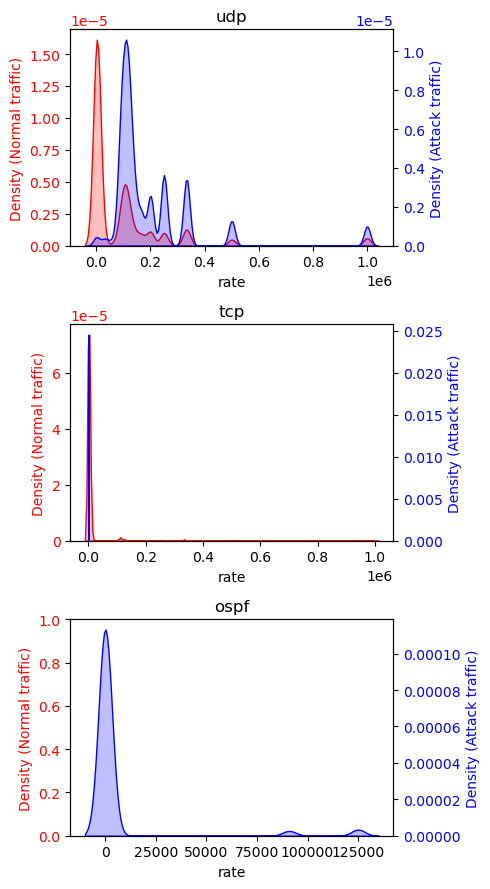

In [14]:
fig, ax = plt.subplots(nrows=df_both_labels['proto'].nunique(), figsize=(5,df_both_labels['proto'].nunique()*3))
for i,p in enumerate(df_both_labels['proto'].unique()):
    print(f'\033[1m{p}:\033[0m')
    temp_df_label_0 = df_both_labels.loc[(df_both_labels['proto']==p) & (df_both_labels['label']==0),'rate']
    temp_df_label_1 = df_both_labels.loc[(df_both_labels['proto']==p) & (df_both_labels['label']==1),'rate']
    print(f'Number of records on normal traffic: {len(temp_df_label_0):,}')
    print(f'Number of records on attack traffic: {len(temp_df_label_1):,}')
    print(f'KS-test statistic: {ks_2samp(temp_df_label_0, temp_df_label_1)[0]}')
    print(f'KS-test p-value: {ks_2samp(temp_df_label_0, temp_df_label_1)[1]}')
    print('Statistically significant difference in distributions\n' if ks_2samp(temp_df_label_0, temp_df_label_1)[1]<0.05 else 'No statistically significant difference in distributions\n')
    ax2 = ax[i].axes.twinx()
    sns.kdeplot(data=df_both_labels[(df_both_labels['proto']==p) & (df_both_labels['label']==0)], x='rate', ax=ax[i], fill=True, cumulative=False, bw_adjust=0.5, color='r', warn_singular=False)
    sns.kdeplot(data=df_both_labels[(df_both_labels['proto']==p) & (df_both_labels['label']==1)], x='rate', ax=ax2, fill=True, cumulative=False, bw_adjust=0.5, color='b', warn_singular=False)
    # sns.kdeplot(data=df_both_labels[df_both_labels['proto']==p], x='rate', hue='label', ax=ax[i], fill=True, cumulative=False, bw_adjust=0.5, color='r', warn_singular=False, common_norm=False)
    ax[i].set_ylabel('Density (Normal traffic)', color='r')
    ax[i].tick_params(axis='y', labelcolor='r')
    ax2.set_ylabel('Density (Attack traffic)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax[i].set_title(p)
plt.tight_layout()
plt.show()

Insights:
- There are three protocols in the data involved in attacks - TCP, UDP and OSPF.
- When collecting traffic, one can distinguish attacks using rate (mostly by UDP).
- TCP can make the attack go off radar while UDP gives a more unique pattern for attack recognition.

## Prediction of attack from features

Using CatBoost model to predict if a record is an attack based on the features (not including id and attack_cat):

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id','attack_cat','label']), df['label'], test_size=0.2, random_state=42)
cat_features = df.drop(columns=['id','attack_cat']).select_dtypes('object').columns.tolist()
model = CatBoostClassifier(n_estimators=100, random_state=42, cat_features=cat_features)
model.fit(X_train, y_train, verbose=False)
y_pred = model.predict(X_test)
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7418
           1       0.98      0.97      0.98      9049

    accuracy                           0.98     16467
   macro avg       0.98      0.98      0.98     16467
weighted avg       0.98      0.98      0.98     16467

Confusion Matrix:
[[7263  155]
 [ 242 8807]]


In [16]:
feature_importance = pd.Series(model.feature_importances_, index=model.feature_names_)

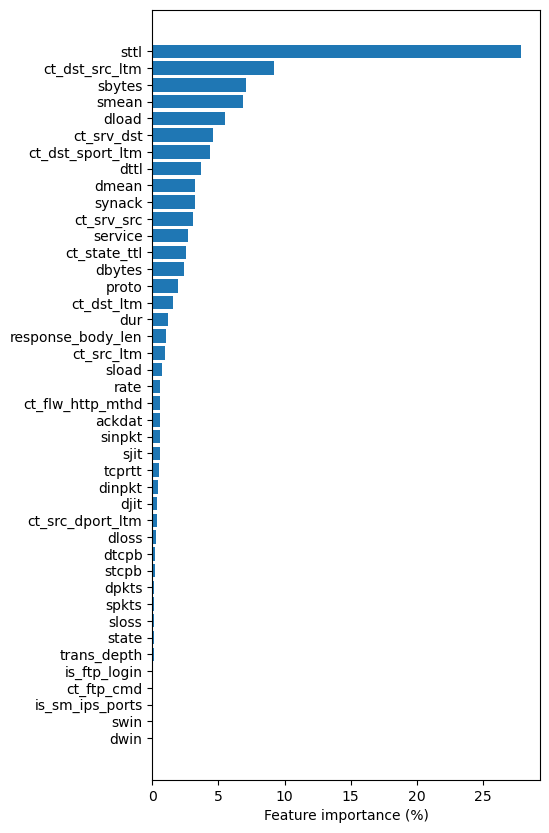

In [17]:
plt.figure(figsize=(5,10))
plt.barh(feature_importance.sort_values(ascending=True).index, feature_importance.sort_values(ascending=True))
plt.xlabel('Feature importance (%)')
plt.show()

Evaluating the most important feature (sttl):

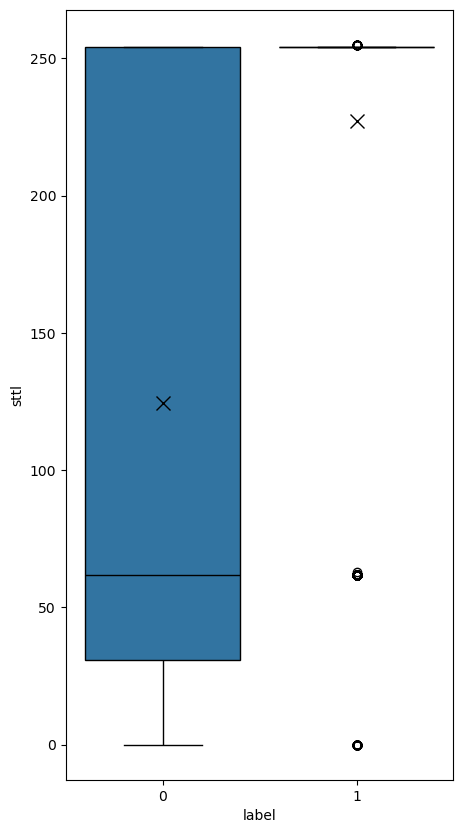

In [22]:
plt.figure(figsize=(5,10))
sns.boxplot(data=df, x='label', y='sttl', showmeans=True, linecolor='k', meanprops={'marker':'x', 'markeredgecolor':'k', 'markersize':10})
plt.show()

Insights:
- Attacks can be predicted by traffic features with accuraccy of 98% (also F1 is 98%)
- The main feature for prediction is the source TTL, which strongly correlates to the attack label.